In [3]:
import numpy as np
from qiskit import pulse, IBMQ, transpile, schedule, execute, QuantumCircuit, assemble
from qiskit.pulse import library, Acquire, AcquireChannel, MemorySlot, ControlChannel,DriveChannel
from qiskit.circuit import Gate
from qiskit.pulse.library import Drag
from qiskit.test.mock import FakeArmonk
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings('ignore')

In [26]:
IBMQ.save_account('84e47768480771b0f65f16b3f25447e5ab6b88d174cccb8271d1d0a3e4fdf3ce875e7f9f2612ad64f6f107644f49d8c6d9cd2619469de103753b4ae7556e703a')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend=provider.get_backend('ibmq_belem')

configrc.store_credentials:WARNING:2022-07-15 19:12:30,719: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-07-15 19:12:32,171: Credentials are already in use. The existing account in the session will be replaced.


In [27]:
backend.configuration().n_qubits

5

In [28]:
backend.configuration().open_pulse

False

In [29]:
backend.configuration().parametric_pulses

['gaussian', 'gaussian_square', 'drag', 'constant']

# Finding Instruction set of Hadamard Gate

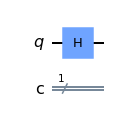

In [30]:
qc=QuantumCircuit(1,1)
qc.h(0)


qc.draw('mpl')

In [31]:
qc_t = transpile(qc,backend)
qc_sched = schedule(qc_t,backend)
print(qc_sched.instructions)

((0, ShiftPhase(-1.5707963268, DriveChannel(0))), (0, ShiftPhase(-1.5707963268, ControlChannel(1))), (0, Play(Drag(duration=160, amp=(0.12206903861761968+0.005401040671124693j), sigma=40, beta=-2.5202988209141224, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), (160, ShiftPhase(-1.5707963268, DriveChannel(0))), (160, ShiftPhase(-1.5707963268, ControlChannel(1))))


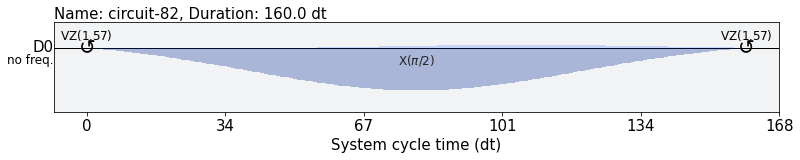

In [32]:
qc_sched.draw()

# Calibrating Custom Hadamard gate

In [47]:
#CHANNELS
dc0 = DriveChannel(0)
cc1 = ControlChannel(1)

In [48]:
#INSTRUCTION SET OF TRANSPILED GATES
drag_amp = 0.12206903861761968+0.005401040671124693j
drag_sigma = 40
dragnum_samples = 160
drag_beta = -2.5202988209141224

drag = library.drag(duration=dragnum_samples,amp=drag_amp,sigma=drag_sigma,beta=drag_beta,name='drag_412b')

M_amp = 0.034103237623472824+0.04936566806594384j
M_sigma = 64
Mnum_samples = 22400
M_width= 2214

M_m0 = pulse.library.GaussianSquare(Mnum_samples,M_amp,M_sigma, M_width, name='M_m0')

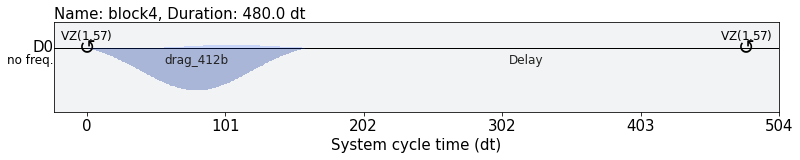

In [49]:
with pulse.build(backend) as drag_pulse:
    pulse.shift_phase(-1.5707963268,dc0)
    pulse.shift_phase(-1.5707963268,cc1)
    pulse.play(drag,dc0)
    pulse.delay(320,dc0)
    pulse.shift_phase(-1.5707963268,dc0)
    pulse.shift_phase(-1.5707963268,cc1)
drag_pulse.draw()

In [50]:
H_cal = Gate(name='Hadamard_cal',label='H',num_qubits=1,params=[])

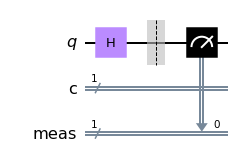

In [51]:
qc1 = QuantumCircuit(1,1)
qc1.append(H_cal,[0])
qc1.measure_all()
qc1.draw('mpl')

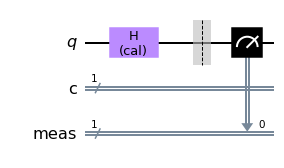

In [52]:
qc1.add_calibration('Hadamard_cal',[0],drag_pulse)
qc1.draw('mpl')

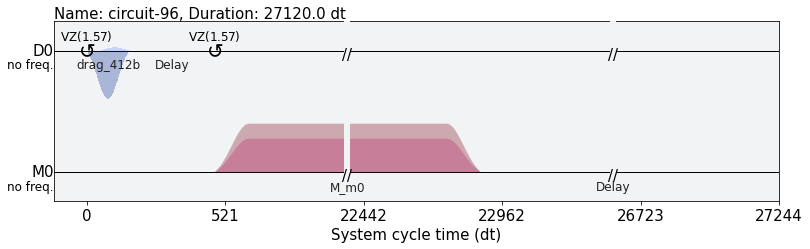

In [53]:
qc1_t = transpile(qc1,backend)
qc1_sched = schedule(qc1_t,backend)
qc1_sched.draw()

In [54]:
job=execute(qc1, backend=backend, shots=2000, optimization_level=0)

In [55]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [56]:
result = job.result()

In [57]:
print(result.get_counts())

{'0 0': 800, '1 0': 1200}


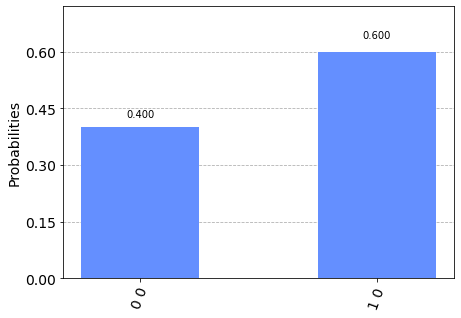

In [58]:
plot_histogram(result.get_counts())

In [16]:
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [17]:
backend_sim = PulseSimulator.from_backend(backend)
backend_sim.configuration().parametric_pulses = []
backend_model = PulseSystemModel.from_backend(backend)

gate_pulse = assemble(qc1_sched,backend,shots=6400)
job = backend_sim.run(gate_pulse,backend_sim)

In [104]:
from qiskit.test.mock import FakeOpenPulse2Q
backend1 = FakeOpenPulse2Q()

In [25]:
drag_pulse.get_waveform()

AttributeError: 'ScheduleBlock' object has no attribute 'get_waveform'

In [23]:
print(job.result().get_counts())
plot_histogram(job.result().get_counts())

AerError: 'Parametric Pulses are not directly supported by PulseSimulator. Convert to\n                explicit WaveForms to simulate.'

In [24]:
from typing import Union, Iterable, Tuple

from qiskit.pulse.instructions import Instruction
from qiskit.pulse.schedule import ScheduleBlock, Schedule
from qiskit.pulse.transforms import canonicalization

InstructionSched = Union[Tuple[int, Instruction], Instruction]


def target_qobj_transform(
    sched: Union[ScheduleBlock, Schedule, InstructionSched, Iterable[InstructionSched]],
    remove_directives: bool = True,
) -> Schedule:
    """A basic pulse program transformation for OpenPulse API execution.
    Args:
        sched: Input program to transform.
        remove_directives: Set `True` to remove compiler directives.
    Returns:
        Transformed program for execution.
    """
    if not isinstance(sched, Schedule):
        # convert into schedule representation
        if isinstance(sched, ScheduleBlock):
            sched = canonicalization.block_to_schedule(sched)
        else:
            sched = Schedule(*_format_schedule_component(sched))

    # remove subroutines, i.e. Call instructions
    sched = canonicalization.inline_subroutines(sched)

    # inline nested schedules
    sched = canonicalization.flatten(sched)

    # remove directives, e.g. barriers
    if remove_directives:
        sched = canonicalization.remove_directives(sched)

    return sched


def _format_schedule_component(sched: Union[InstructionSched, Iterable[InstructionSched]]):
    """A helper function to convert instructions into list of instructions."""
    # TODO remove schedule initialization with *args, Qiskit-terra/#5093

    try:
        sched = list(sched)
        # (t0, inst), or list of it
        if isinstance(sched[0], int):
            # (t0, inst) tuple
            return [tuple(sched)]
        else:
            return sched
    except TypeError:
        return [sched]